# Gene count VAE experiments
Experiments with spatial data: The VAE is trained with the gene count vectors.

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
import torch
import torch.nn as nn

from models.vae_model.linear_vae import VAE_LINEAR
from models.vae_model.model_config import LinearVAEConfig
from models.loss_functions import mse_loss_function
from dataset.gene_counts_dataset import GeneCountDataset

In [2]:
%load_ext autoreload
%autoreload 2

## Global variables

In [3]:
DATA_PATH = "_data_/segmentation/"

In [4]:
CUDA_DEVICE_NUM = 2
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

Device: cuda:2


## Helperfunctions

In [5]:
def visualize_gene_count_reconstruction(vae_model, test_data_iterator):
    fig, axes = plt.subplots(2, 4, figsize=(10, 2))

    test_batch = next(test_data_iterator)
    example_images = test_batch[0].to(DEVICE)
    x_flat, _, _ = vae_model(example_images)
    x_reconstructed = x_flat.view(-1, 1, 5, 23)

    for i in range(4):
        img = example_images[i].cpu().detach().numpy()
        img_reshaped = np.squeeze(img).reshape((5, 23))
        img_recon = x_reconstructed[i].cpu().detach().numpy()

        uint8_image = img_reshaped.astype(np.uint8)
        uint8_image_recon = np.squeeze(img_recon).astype(np.uint8)

        axes[0, i].imshow(uint8_image, cmap='gray')
        axes[0, i].axis('off')

        axes[1, i].imshow(uint8_image_recon, cmap='gray')
        axes[1, i].axis('off')

    fig.suptitle('Reconstruction examples', fontsize=16, y=0.8)
    plt.tight_layout()

## Data load

## Gene count experiment
This experiment uses the gene counts as input samples.  
Each input `x` is a vectore of length 115 which represents the count per gene of in the cell.

#### VAE

In [6]:
EPOCHS = 50
BATCH_SIZE = 32
N_GENES = 115
Z_DIM = 50

In [7]:
linear_config = {
    "model_config": {
        "hidden_dims": [300, 200, 100], # Dimmension of hidden layers
        "z_dim": Z_DIM,
        "input_dim": N_GENES
    },
    "hyperparameters": {
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE
    }
}
config_object = LinearVAEConfig(**linear_config)

In [8]:
cell_meta_df = pd.read_csv(os.path.join(DATA_PATH, "cell_meta_data.csv"))

gene_count_df = pd.read_csv(os.path.join(DATA_PATH, "gene_counts.csv"))
gene_count_df.set_index("cell_index", inplace=True)

In [10]:
cell_meta_df = pd.read_csv(os.path.join(DATA_PATH, "transcripts.csv"))
cell_meta_df

,gene,barcode_id,x,y,cell_index,fov
0,Tmem119,104,1488.30760,275.79810,0_0,0
1,Tmem119,104,1917.46340,1550.89270,0_0,0
2,Tmem119,104,1507.42460,1828.72770,0_0,0
3,Fcrls,40,1311.61820,1308.89880,0_0,0
4,Eif3f,34,1511.89420,81.69420,0_0,0
...,...,...,...,...,...,...
11867300,Shroom3,35,376.57013,481.29892,119_0,119
11867301,Bcl11b,3,354.98557,471.98940,119_0,119
11867302,Moxd1,26,722.20416,1789.81980,119_0,119
11867303,Neurod2,28,353.81418,467.59146,119_0,119


In [61]:
training_fov_range = range(52)
gene_count_train_dataset = GeneCountDataset(
    cell_meta_df=cell_meta_df[cell_meta_df['fov'].isin(training_fov_range)],
    gene_count_df=gene_count_df
)
gene_count_train_loader = DataLoader(dataset=gene_count_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_fov_range = range(52, 60)
gene_count_test_dataset = GeneCountDataset(
    cell_meta_df=cell_meta_df[cell_meta_df['fov'].isin(test_fov_range)],
    gene_count_df=gene_count_df
)
gene_count_test_loader = DataLoader(dataset=gene_count_test_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_data_iterator = iter(gene_count_test_loader)

In [62]:
vae_linear = VAE_LINEAR(config_object.model_config)
vae_linear.to(DEVICE)

# calculate the 'kl_weight'
kl_weight = BATCH_SIZE / len(gene_count_train_loader.dataset)

loss_function = mse_loss_function(kl_weight, 1)
optimizer = torch.optim.Adam(vae_linear.parameters(), lr=0.005)

In [63]:
test_batch = next(test_data_iterator)
example_images = test_batch[0].to(DEVICE)
vae_linear.test_shape(example_images)

Shape of input x: torch.Size([32, 115])
Shape of encoded x: torch.Size([32, 100])
Shape of latent vector z: torch.Size([32, 50])
Shape of reconstructed x: torch.Size([32, 115])


#### Training loop

In [64]:
float32_info = torch.finfo(torch.float32)
min_training_loss = (-1, float32_info.max)

for epoch in range(EPOCHS):
    for batch_idx, (features, _) in enumerate(gene_count_train_loader):
        x = features.to(DEVICE)

        x_recontsructed, z_mean, z_sigma = vae_linear.forward(x)
        
        loss = loss_function(x, x_recontsructed, z_mean, z_sigma)

        loss_value = loss.item()
        if loss_value < min_training_loss[1]:
            min_training_loss = (epoch, loss_value)
            torch.save(vae_linear.state_dict(), "_data_/models/vae_linear_best_epoch.pt")
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 5 == 0:
        print(f'Epoch: {epoch+1}, Loss: {loss_value:.4f}')

print(f'Best loss: {min_training_loss[1]:.4f} in epoch: {min_training_loss[0]+1}')

Epoch: 5, Loss: 8.5595
Epoch: 10, Loss: 8.5341
Epoch: 15, Loss: 10.2943
Epoch: 20, Loss: 10.4700
Epoch: 25, Loss: 22.2849
Epoch: 30, Loss: 12.9042
Epoch: 35, Loss: 7.1193
Epoch: 40, Loss: 7.5236
Epoch: 45, Loss: 11.9259
Epoch: 50, Loss: 4.1871
Best loss: 2.7663 in epoch: 42


#### Evaluate model reconstruction
Evaluate the best model on the test set by plotting reconstruction examples

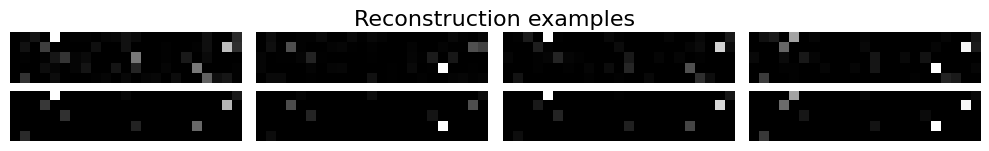

In [70]:
vae_linear.load_state_dict(torch.load("_data_/models/vae_linear_best_epoch.pt"))
vae_linear.to(DEVICE)
vae_linear.eval()

visualize_gene_count_reconstruction(vae_linear, test_data_iterator)